# Что и зачем 
Хочу как минимум иметь актуальную статистику по коронавирусу. Как максимум - попытаться спрогнозировать 
продолжительность и массовой эпидемии и карантина (хочу отметить майские праздники)

### Откуда данные

~~Данные взяты [отсюда](https://github.com/CSSEGISandData/COVID-19)~~

Теперь данные беру [здесь](https://github.com/ulklc/covid19-timeseries), 
предыдущий источник очень любил часто и без предупреждения менять формат данных.
(соответствуют данным ВОЗ, но очень удобно скомпанованы в CSV по дням).

Обновляются ежедневно, как отмечает автор, в 23:59 UTC. По Москве это в 02:59 ночи. Точность не проверл.

~~Сами данные тоже местами странноватые: есть взять начало марта и посмотреть на РФ, то мы увидим падение кол-ва зарегистрированных случаев коронавируса (09.03 - 10.03). Но в остальном похожи на правду.~~
В новом источнике данные больше похожи на правду, подобных ошибок не зачемено.

Собственно собираем данные. 

Таблица слегка кривая, но тут уж извените)

In [1]:

import pandas as pd

pd.set_option("display.max_rows", None, "display.max_columns", None)
df = pd.read_csv('https://raw.githubusercontent.com/ulklc/covid19-timeseries/master/countryReport/country/RU.csv')

print(df[['day', 'confirmed', 'death', 'recovered']])


           day  confirmed  death  recovered
0   2020/01/22          0      0          0
1   2020/01/23          0      0          0
2   2020/01/24          0      0          0
3   2020/01/25          0      0          0
4   2020/01/26          0      0          0
5   2020/01/27          0      0          0
6   2020/01/28          0      0          0
7   2020/01/29          0      0          0
8   2020/01/30          0      0          0
9   2020/01/31          2      0          0
10  2020/02/01          2      0          0
11  2020/02/02          2      0          0
12  2020/02/03          2      0          0
13  2020/02/04          2      0          0
14  2020/02/05          2      0          0
15  2020/02/06          2      0          0
16  2020/02/07          2      0          0
17  2020/02/08          2      0          0
18  2020/02/09          2      0          0
19  2020/02/10          2      0          0
20  2020/02/11          2      0          0
21  2020/02/12          2      0

Вычисляем и выводим тренд распространения.

### Что за тренд.
Хоть какой-то показатель скорости распространения коронавируса. Считал так:
1. Для начала я вычисляю 'заразность дня', то есть отношение 
> (кол-во подтвержденых случаев сегодня - кол-во подтвержденых случаев вчера) к количеству больных вчера.
2. Средний тренд распространения я считал как среднее арифметическое трендов за все дни наблюдения. 
Как вариант сделать несколько трендов: за неделю/месяц/все время - хз как правильно.

> Подемать насчет время среднего тренда = инкубационный период.

У 'заразности дня' есть ощутимый косяк - например для данных по РФ за конец февраля получается деление на 0 (связано с 
тем: что кол-во диагностированных заболеваний = кол-ву выздоровевших). В тренде распространения дни с этим косяком не 
использовал совсем (это может быть проблемой: так как может повышать тренд).

P.S. Не уверен, что именно так стоит считать заразность.

In [2]:

tmp_all_propagation = 0
tmp_days_of_propagation = 0
propagation = {}
prev_confirmed = None
prev_sick = None

for index, row in df.iterrows():
    if index != 0 and prev_sick and prev_sick != 0 and prev_confirmed:
        propagation[row['day']] = 1 + (row['confirmed'] - prev_confirmed) / prev_sick
        tmp_all_propagation += propagation[row['day']]
        tmp_days_of_propagation += 1
    else:
        propagation[row['day']] = 0
    prev_confirmed = row['confirmed']
    prev_sick = prev_confirmed - row['death'] - row['recovered']

average_propagation = tmp_all_propagation / tmp_days_of_propagation

print(f'Средний тренд распространения: {average_propagation}')


Средний тренд распространения: 1.2903996780683578


### Строим графички

На первом графике все просто: текущая ситуация, кол-во больных/переболевших/мертвых.

На третьем графике соотношение выздоровевших/умерших. Особо ничего не показывает, но мне почему-то показалось важным 
нарисовать такой график.

На втором графике самое интереснок: описанный выше тренд указан красным, синим нарисована 'заразность дня'.

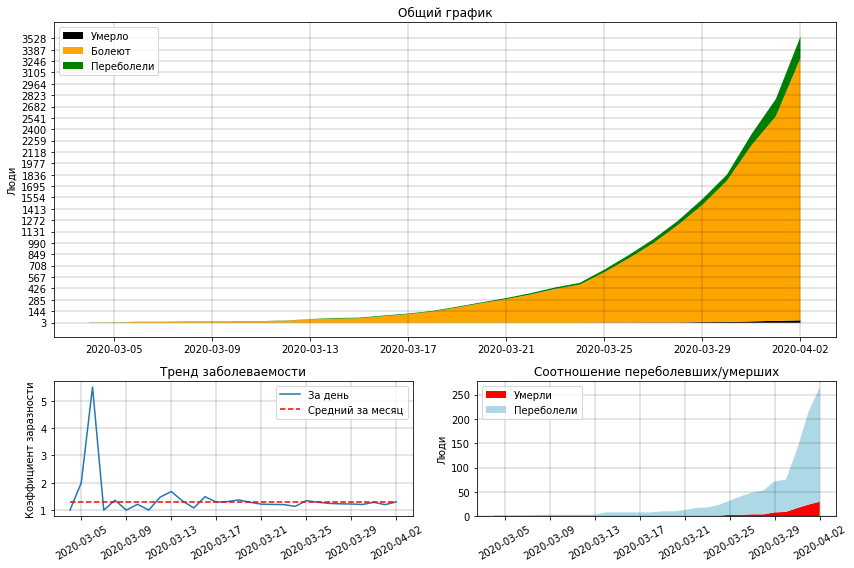

In [3]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


show_days = 30

x = [datetime.date(datetime.strptime(i, '%Y/%m/%d')) for i in df['day'][-show_days:]]
y1 = [row['death'] for _, row in df.iterrows()][-show_days:]
y2 = [row['confirmed'] - row['death'] - row['recovered'] for _, row in df.iterrows()][-show_days:]
y3 = [row['confirmed'] for _, row in df.iterrows()][-show_days:]
y4 = [propagation[row['day']] for _, row in df.iterrows()][-show_days:]
y5 = [average_propagation for i in range(show_days)][-show_days:]
y6 = [row['recovered'] for _, row in df.iterrows()][-show_days:]
xticks = [datetime.date(datetime.today() - timedelta(days=i)) for i in range(1, show_days, 4)]
yticks = [i for i in range(y3[0], y3[-1], (y3[-1]-y3[0])//25)]

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))

ax1.fill_between(x, 0, y1, facecolor='black', label='Умерло')
ax1.fill_between(x, y1, y2, facecolor='orange', label='Болеют')
ax1.fill_between(x, y2, y3, facecolor='green', label='Переболели')
ax1.set_title('Общий график')
ax1.legend(loc='upper left')
ax1.set_ylabel('Люди')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.grid(color='black', linestyle='-', linewidth=0.2)


ax2.plot(x, y4, label='За день')
ax2.plot(x, y5, 'r--', label='Средний за месяц')
ax2.set_title('Тренд заболеваемости')
ax2.legend(loc='upper right')
ax2.set_ylabel('Коэффициент заразности')
ax2.tick_params(axis='x', rotation=30)
ax2.set_xticks(xticks)
ax2.grid(color='black', linestyle='-', linewidth=0.2)


ax3.stackplot(x, y1, y6, labels=['Умерли', 'Переболели'], colors=['red', 'lightblue'])
ax3.set_title('Соотношение переболевших/умерших')
ax3.legend(loc='upper left')
ax3.set_ylabel('Люди')
ax3.tick_params(axis='x', rotation=30)
ax3.set_xticks(xticks)
ax3.grid(color='black', linestyle='-', linewidth=0.2)


fig.tight_layout()
plt.show()


# Странности

- Воскресший в РФ человек, есть [Issue на гитхабе](https://github.com/CSSEGISandData/COVID-19/issues/1331)
- С 09.03 на 10.03 7 человек пропали. Мб депортировали, но вряд ли. TBD погуглить.
- Формат данных в исочнике имеет неприятную особенность меняться:
  - Из-за этого у класса `Country` появилась переменная alt_name
  - По этой же причине на текущий момент отсутствуют данные за 23.03,
  [pull request](https://github.com/CSSEGISandData/COVID-19/pull/1339) (в комментах накидал issue)